## 資料處理

In [26]:
import numpy as np
import pandas as pd
np.set_printoptions(precision = 4, suppress = True)

# 讀資料
df = pd.read_excel("C:/Users/User/Desktop/金融計量/data2.xlsx",parse_dates = ["date"] )

y = np.column_stack([df["delta_d"].values, 
                     -np.log(df["DY"]/100).values])
y = y[~np.isnan(y).any(axis = 1)].T


## Negative log-likelihood

In [27]:
def neg_loglik(theta, y):
    # theta = [delta0, delta1, gamma0, gamma1, rho, kappa, q_mu, q_g, wd]

    # A, B1, B2
    A = theta[5]/(1 - theta[4]) + (theta[2] - theta[0])/(1 - theta[4])
    B1 = 1/(1 - theta[4]*theta[1])
    B2 = 1/(1 - theta[4]*theta[3])

    # state transition equation
    dt = np.array([[theta[0]*(1 - theta[1])], 
                   [theta[2]*(1 - theta[3])]])
    Tt = np.array([
        [theta[1], 0], 
        [0, theta[3]]
    ])
    Q = np.array([
        [max(theta[6], 0), 0], 
        [0, max(theta[7], 0)]
    ])

    # measurement equation
    ct = np.array([[0], 
                   [A + B1*theta[0] - B2*theta[2]]])
    Zt = np.array([
        [0, 1], 
        [-B1, B2]
    ])
    W = np.array([
        [np.sqrt(max(theta[8], 0)), 0], 
        [0, 0]
    ])

    # 初始設定
    a0 = np.array([[0.0038],  # delta_d mean
                   [3.2]])   # pdt mean
    P0 = np.array([
        [0.1, 0], 
        [0, 0.1]
    ])
    loglik = 0

    # Kalman filter
    for i in range(y.shape[1]):
        # prediction step
        a_pred = dt + Tt @ a0
        P_pred = Tt @ P0 @ Tt.T + Q

        # Prediction error
        vt = y[:, [i]] - (ct + Zt @ a_pred)
        Ft = Zt @ P_pred @ Zt.T + W @ W.T
        Ft = (Ft + Ft.T)/2  # 保證對稱
        Ft += 1e-4 * np.eye(2)  # jitter
        
        # check positive definite
        sign, logdet = np.linalg.slogdet(Ft)
        if sign <= 0:
            return 1e4

        # Kalman gain
        Kt = P_pred @ Zt.T @ np.linalg.inv(Ft)

        # update step
        att = a_pred + Kt @ vt
        Ptt = P_pred - Kt @ Zt @ P_pred
        loglik += -0.5 * (logdet + float(vt.T @ np.linalg.inv(Ft) @ vt) + 2 * np.log(2*np.pi))

        # next iteration
        a0 = att
        P0 = Ptt

    return -loglik

## 第一次結果

In [28]:
from scipy.optimize import minimize
# 初始值
theta0 = np.array([0.09, 0.92, 0.06, 0.4, 0.96, 0.1, 0.03, 0.08, 0.0001])

# 最大概似估計
bounds = [
    (None, None),  # delta0
    (0.9, 0.99), # delta1 AR(1) 係數
    (None, None),  # gamma0
    (0, 0.99), # gamma1 AR(1) 係數 
    (0.9, 0.999), # rho
    (None, None),  # kappa
    (1e-4, None),  # q_mu 變異數
    (1e-4, None),  # q_g 變異數
    (1e-4, None)   # wd 變異數
]
res = minimize(neg_loglik, theta0, args=(y,), method="L-BFGS-B", bounds = bounds)
print("Converged:", res.success, res.message)
print("theta_hat:", res.x)

C:\Users\User\AppData\Local\Temp\ipykernel_5472\988144647.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  loglik += -0.5 * (logdet + float(vt.T @ np.linalg.inv(Ft) @ vt) + 2 * np.log(2*np.pi))


Converged: True CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
theta_hat: [-0.0788  0.9002 -0.0554  0.2862  0.9005  0.274   0.0004  0.0008  0.0363]


## Sensitive test

In [29]:
base = np.array([0.09, 0.92, 0.06, 0.4, 0.96, 0.1, 0.03, 0.08, 0.0001])
delta1_try = [0.95]
gamma1_try = [0.3, 0.6]
q_g_try = [0.001]
results = []
bounds2 = [
    (None, None),  # delta0
    (-0.99, 0.99), # delta1 AR(1) 係數
    (None, None),  # gamma0
    (-0.99, 0.99), # gamma1 AR(1) 係數 
    (-0.99, 0.999), # rho
    (None, None),  # kappa
    (1e-8, 1),  # q_mu 變異數
    (1e-8, 1),  # q_g 變異數
    (1e-8, 1)   # wd 變異數
]

# delta1 try
for d1 in delta1_try:
    initial = base.copy()
    initial[1] = d1
    res = minimize(neg_loglik, initial, args = (y,), method="L-BFGS-B", bounds = bounds2)
    results.append({
        "case": "delta1 sensitivity", 
        "initial": d1,
        "coverged": res.success, 
        "theta_hat": res.x
    })

# gamma1 try
for g0 in gamma1_try:
    initial = base.copy()
    initial[3] = g0
    res = minimize(neg_loglik, initial, args = (y,), method="L-BFGS-B", bounds = bounds2)
    results.append({
        "case": "gamma1 sensitivity", 
        "initial": g0,
        "coverged": res.success, 
        "theta_hat": res.x
    })

# q_mu try
for q0 in q_g_try:
    initial = base.copy()
    initial[7] = q0
    res = minimize(neg_loglik, initial, args = (y,), method="L-BFGS-B", bounds = bounds2)
    results.append({
        "case": "q_g sensitivity", 
        "initial": q0,
        "coverged": res.success, 
        "theta_hat": res.x
    })


# results
df_results = pd.DataFrame(results)
df_results

C:\Users\User\AppData\Local\Temp\ipykernel_5472\988144647.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  loglik += -0.5 * (logdet + float(vt.T @ np.linalg.inv(Ft) @ vt) + 2 * np.log(2*np.pi))


,case,initial,coverged,theta_hat
0,delta1 sensitivity,0.950,True,"[-0.12570159057185146, 0.9384649552521255, 0.0..."
1,gamma1 sensitivity,0.300,True,"[-0.126234263144975, 0.9384761078649715, 0.003..."
2,gamma1 sensitivity,0.600,True,"[-0.004518838438663168, 0.9322557912572504, 0...."
3,q_g sensitivity,0.001,True,"[0.00984657559203795, 0.936585680094479, 0.003..."


## regression

In [30]:
import statsmodels.api as sm

# rt+1
df["rp"] = np.log(df["P"]).diff()
df["r_true"] = df["rp"] + np.log(1 + (df["DY"]/100).shift(1))

# rt to rt+1
r_true = df["r_true"].dropna().reset_index(drop = True)
rt = r_true[:-1].values
rt1 = r_true[1:].values
X1 = sm.add_constant(rt)
model1 = sm.OLS(rt1, X1).fit()
const1 = model1.params[0]
delta1 = model1.params[1]
q_mu_est = model1.mse_resid   # q_mu
print("delta0 ≈", const1/(1 - delta1), "delta1 ≈", delta1, "q_mu ≈", q_mu_est)

# delta_dt to delta_dt+1
delta_d = df["delta_d"].dropna().reset_index(drop = True)
delta_dt = delta_d.shift(1).dropna().values
delta_dt1 = delta_d[1:].values
X2 = sm.add_constant(delta_dt)
model2 = sm.OLS(delta_dt1, X2).fit()
const2 = model2.params[0]
gamma1 = model2.params[1]
resid2 = model2.mse_resid
print("gamma0 ≈", const2/(1 - gamma1), "gamma1 ≈", gamma1, "residual ≈", resid2)

delta0 ≈ 0.04333663292101543 delta1 ≈ 0.09411318765366931 q_mu ≈ 0.0034256055978415458
gamma0 ≈ 0.0034793151036377843 gamma1 ≈ -0.2556741019202367 residual ≈ 0.00806647690280164


## 第一次結果 (rerun)

In [31]:
from scipy.optimize import minimize
# 初始值
theta0 = np.array([0.04, 0.09, 0.003, -0.26, 0.95, 0.1, 0.003, 0.008, 0.0001])

bounds = [
    (None, None),  # delta0
    (-0.99, 0.99), # delta1 AR(1) 係數
    (None, None),  # gamma0
    (-0.99, 0.99), # gamma1 AR(1) 係數 
    (-0.99, 0.999), # rho
    (None, None),  # kappa
    (1e-8, 1),  # q_mu 變異數
    (1e-8, 1),  # q_g 變異數
    (1e-8, 1)   # wd 變異數
]

res = minimize(neg_loglik, theta0, args=(y,), method="L-BFGS-B", bounds = bounds)
print("Converged:", res.success, res.message)
print("theta_hat:", res.x)

C:\Users\User\AppData\Local\Temp\ipykernel_5472\988144647.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  loglik += -0.5 * (logdet + float(vt.T @ np.linalg.inv(Ft) @ vt) + 2 * np.log(2*np.pi))


Converged: True CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
theta_hat: [ 0.0592  0.0926 -0.0165 -0.2597  0.9984  0.0808  0.0257  0.0035  0.0072]


## 第二次 Kalman filter

In [32]:
theta_hat = res.x

def fkf2(theta, y):
    # theta = [delta0, delta1, gamma0, gamma1, rho, kappa, q_mu, q_g, wd]

    # A, B1, B2
    A = theta[5]/(1 - theta[4]) + (theta[2] - theta[0])/(1 - theta[4])
    B1 = 1/(1 - theta[4]*theta[1])
    B2 = 1/(1 - theta[4]*theta[3])

    # state transition equation
    dt = np.array([[theta[0]*(1 - theta[1])], 
                   [theta[2]*(1 - theta[3])]])
    Tt = np.array([
        [theta[1], 0], 
        [0, theta[3]]
    ])
    Q = np.array([
        [max(theta[6], 0), 0], 
        [0, max(theta[7], 0)]
    ])

    # measurement equation
    ct = np.array([[0], 
                   [A + B1*theta[0] - B2*theta[2]]])
    Zt = np.array([
        [0, 1], 
        [-B1, B2]
    ])
    W = np.array([
        [np.sqrt(max(theta[8], 0)), 0], 
        [0, 0]
    ])

    # 初始設定
    a0 = np.array([[0.0038],  # delta_d mean
                   [3.2]])  # pdt mean
    P0 = np.array([
        [0.1, 0], 
        [0, 0.1]
    ])

    att_list = []
    yhat_list = []
    
    # Kalman filter
    for i in range(y.shape[1]):
        # prediction step
        a_pred = dt + Tt @ a0
        P_pred = Tt @ P0 @ Tt.T + Q

        # Predicted y
        y_pred = ct + Zt @ a_pred
        yhat_list.append(y_pred.flatten())

        # Prediction error
        vt = y[:, [i]] - (ct + Zt @ a_pred)
        Ft = Zt @ P_pred @ Zt.T + W @ W.T
        Ft = (Ft + Ft.T)/2  # 保證對稱
        Ft += 1e-4 * np.eye(2)  # jitter
        
        # check positive definite
        sign, logdet = np.linalg.slogdet(Ft)
        if sign <= 0:
            return 1e4

        # Kalman gain
        Kt = P_pred @ Zt.T @ np.linalg.inv(Ft)

        # update step
        att = a_pred + Kt @ vt
        Ptt = P_pred - Kt @ Zt @ P_pred

        att_list.append(att.flatten())
        
        # next iteration
        a0 = att
        P0 = Ptt

    return np.array(att_list), np.array(yhat_list)

att, yhat = fkf2(theta_hat, y)

att_df = pd.DataFrame(att, 
                      columns = ["mu_hat", "g_hat"], 
                      index = df.loc[~np.isnan(df["delta_d"]), "date"].iloc[:len(att)].reset_index(drop = True))
att_df

,mu_hat,g_hat
date,,
2000-02-01,-0.543558,-0.196238
2000-03-01,-0.420196,0.029674
2000-04-01,-0.298309,0.053433
2000-05-01,-0.365560,-0.045144
2000-06-01,-0.157635,0.062159
...,...,...
2025-04-01,-0.111903,-0.018362
2025-05-01,-0.151434,-0.019301
2025-06-01,-0.182947,-0.006636


## R^2

In [33]:
# rt+1
df["rp"] = np.log(df["P"]).diff()
df["r_true"] = df["rp"] + np.log(1 + (df["DY"]/100).shift(1))

# mu_hat
mu_pred = att_df["mu_hat"].reset_index(drop = True)

# baseline
r_true = df["r_true"].dropna().reset_index(drop = True)
r_bar = np.mean(df["r_true"].dropna())
denominator = np.sum((r_true - r_bar)**2)

# R^2
numerator = np.sum((r_true - mu_pred)**2)
R_squared = 1 - (numerator/denominator)
R_squared

np.float64(-14.360806002827829)

## plot (μ_t filtered)

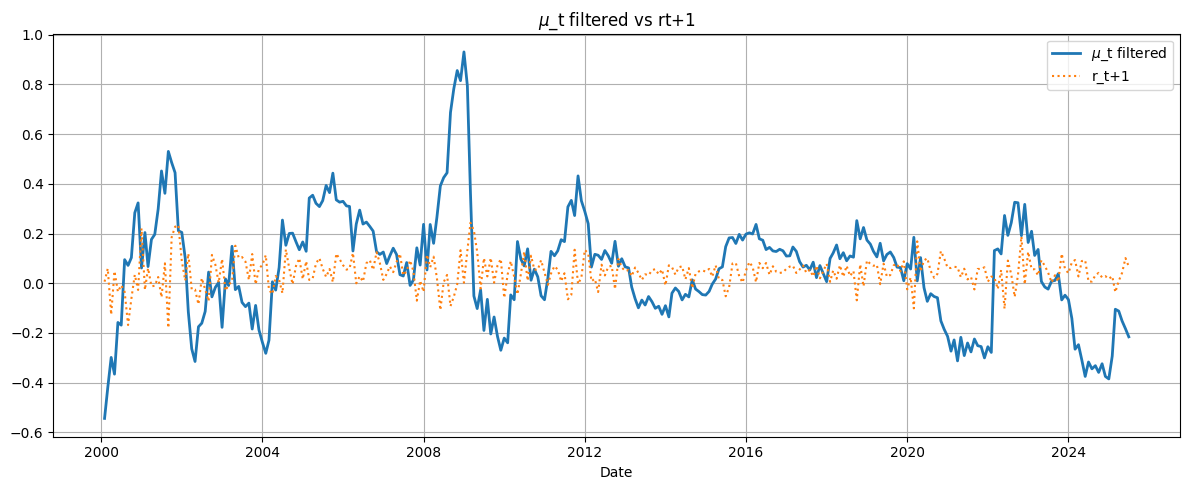

In [34]:
import matplotlib.pyplot as plt

# mu_hat
mu_pred = att_df['mu_hat'].reset_index(drop=True)

# align lengths
n = min(len(mu_pred), len(rt1))
mu_plot = mu_pred[:n]
rt1_plot = rt1[:n]
dates = att_df.index[:n]
plt.figure(figsize=(12,5))
plt.plot(dates, mu_plot, label=r'$\mu$_t filtered', linewidth=2)
plt.plot(dates, rt1_plot, label='r_t+1', linestyle = ":")
plt.legend()
plt.title(r'$\mu$_t filtered vs rt+1')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()


## plot (g_t filtered)

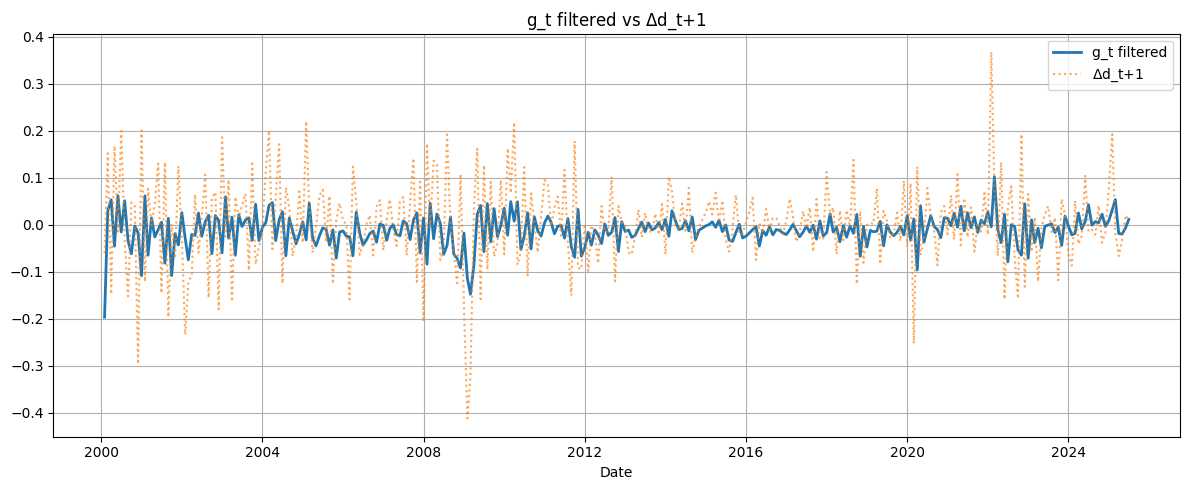

In [35]:
# g_hat
gt_pred = att_df["g_hat"].reset_index(drop = True)

# align lengths
n = min(len(gt_pred), len(delta_dt1))
gt_plot = gt_pred[:n]
delta_dt1_plot = delta_dt1[:n]
dates = att_df.index[:n]
plt.figure(figsize = (12, 5))
plt.plot(dates, gt_plot, label = "g_t filtered", linewidth = 2)
plt.plot(dates, delta_dt1_plot, label = r"$\Delta$d_t+1", alpha = 0.7, linestyle = ":")
plt.legend()
plt.title(r"g_t filtered vs $\Delta$d_t+1")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()
